# Franck Hertz Experiment

### Introduction

In this workshop you will import data from the Franck Hertz laboratory and analyse it to find the excitation energy of Hg.

_Note:_ This requires that you have saved data from the Tektronix oscilloscope in CSV format, with both channels (`CH1` and `CH2`) present in the same file. 

### Package imports

First we import some standard packages, `numpy`, `pandas`, and `matplotlib.pyplot`, and `lmfit`. Since we don't wish to prefix every function call of these packages with the full package name, we use the aliases `np`, `pd`, and `plt`, respectively.

**Execute code cells by clicking on them and pressing the 'Run' button above (play icon), or pressing `Shift+Enter` on your keyboard.** 

_Note_: For those exercises where a solution has been provided, you will also need to execute these cells.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lmfit
from scipy import signal

___
### Exercise 1: Importing the data
Use the function `pd.read_csv` to import the data from a CSV file, corresponding to voltage measurements made in XY mode of the oscilloscope. 

  * Specify values for the arguments `io`, `header`, and `index_col`.
  * Use `skip_blank_lines=True` to avoid an annoying pathology where Excel will convert blank lines to ",,," which is deemed by pandas to be an empty (but not blank) row.
  * Use `keep_default_na=False` to prevent any empty rows at the end of the file being imported.
  * If you're unsure of the meaning of these arguments, type `pd.read_csv?` into an empty cell and press `Shift+Enter`.
  * Once you've successfully executed this function, store the result in a new variable named `df` (this is a conventional variable name for the `pandas.DataFrame` type.
  * Display a subset of the data by executing the statement `df.head()`.

#### Soluton

In [2]:
filepath = 'StudentData\\TEK00000.CSV' # Change this to the path of your CSV file
df = pd.read_csv(filepath, header=14, index_col=0)
df.tail()

,CH1,CH2
TIME,,
0.009876,1.29102,-8.13477
0.009877,1.29102,-8.13477
0.009878,1.28516,-7.87891
0.009878,1.28516,-7.87891
0.009879,1.23145,-7.68359


___
### Exercise 2: Getting the metadata

The CSV file also contains some metadata regarding the scaling, offsets, and timing of the acquired data.

  * Use another call to `pd.read_csv` to get the metadata, this time specifying the `header` row as `None`, the number of rows to import `nrows`, the column to use as an index (`index_col`), and the rows to skip (`skiprows`).
  * Assign this import statement to a variable named `header`.
  * Redefine `header.columns` to be the channel labels, attained using `df.columns`.
  * Evaluate the sampling interval (a time in seconds) and assign this to a variable `dt`.
  * Make a pandas `TimedeltaIndex` using `pd.timedelta_range` and `dt` that can be used to reindex the data itself.
  * Assign this `TimedeltaIndex` to `df.index`.

#### Solution

In [3]:
header = pd.read_csv(filepath, header=None, nrows=12, index_col=0, skiprows=3)
header.index.name = 'Setting'
header.columns = df.columns
header

,CH1,CH2
Setting,,
Point Format,Y,NaN
Horizontal Units,S,NaN
Horizontal Scale,0.001,NaN
Sample Interval,8e-07,NaN
Filter Frequency,1e+08,NaN
Record Length,20000,NaN
Gating,0.0% to 100.0%,0.0% to 100.0%
Probe Attenuation,10,10
Vertical Units,V,V


___
### Exercise 3: Re-indexing the time-domain data

The dataframe is indexed by time readings from the oscilloscope, which do not necessarily start at zero. Furthermore, the time values are evenly spaced, but this is not acknowledged in the dataframe's index. Here we will use a special type of pandas index for time-series data, a `TimedeltaIndex`, which acknowledges the periodic sampling and allows us to easily perform resampling for a moving average in a later exercise.

  * Define the sampling interval `dt` using the value of `header['CH1']['Sample Interval']`. _Note:_ You will need to convert this to `float` as it may be a string.
  * Create a `TimedeltaIndex` using `pd.timedelta_range`, specifying `start=0`, `periods=len(df)`, and `freq=f"{1e9*dt:.1f}ns"`. This final argument automatically generates the string-formatting required by `pandas` based on the numeric value of `dt`. For example, if `dt` is equal to `8.e-7` (800 ns), the resulting value of the `freq` argument is `"800ns".
  * Assign this to `df.index`.

#### Solution

In [4]:
dt = float(header['CH1']['Sample Interval'])
df.index = pd.timedelta_range(start=0, freq=f"{1e9*dt:.1f}ns", periods=len(df))
df.index

TimedeltaIndex([       '00:00:00', '00:00:00.000000', '00:00:00.000001',
                '00:00:00.000002', '00:00:00.000003', '00:00:00.000004',
                '00:00:00.000004', '00:00:00.000005', '00:00:00.000006',
                '00:00:00.000007',
                ...
                '00:00:00.015992', '00:00:00.015992', '00:00:00.015993',
                '00:00:00.015994', '00:00:00.015995', '00:00:00.015996',
                '00:00:00.015996', '00:00:00.015997', '00:00:00.015998',
                '00:00:00.015999'],
               dtype='timedelta64[ns]', length=20000, freq='800N')

___
### Exercise 4: Plotting the data

  * Use `df.plot(x='CH1', y='CH2')` to plot the XY data parameterically.
  * Add axes labels using `plt.xlabel` and `plt.ylabel`.
  * Change the axes range using `plt.axis` to display the area of interest for further analysis. Limit this region to show only clearly deliniated transmission dips. 
  * Add grid lines using `plt.grid`.

#### Solution

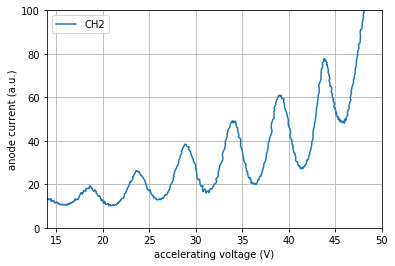

In [5]:
df.plot(x='CH1', y='CH2')
plt.xlabel('accelerating voltage (V)')
plt.ylabel('anode current (a.u.)')
plt.axis(xmin=14, xmax=50, ymin=0, ymax=100)
plt.grid()
plt.show()

___
### Exercise 5: Getting a subset of the data

  * Define `val_filter`, a list of boolean values that correspond to points within the region of interest plotted above, which you'll use for further analysis. Do this using compound logic statements such as `(df.CH1 >= xmin) & (df.CH1 < xmax) & (...)`, where `xmin`, `xmax`, `ymin`, and `ymax` are those values selected in the call to `plt.axis` in the above exercise.
  * Use this boolean array to extract a subset of the data, assigning the result to a variable `subdf`. When doing so, also call the `resample` method of the `DataFrame` to take a moving average with a 10 microsecond window, i.e. assign `df[val_filter].resample('10us').mean()` to `subdf`.
  * Drop any `NaN` values resulting from the resampling by calling `subdf.dropna(inplace=True)`.
  * Finally, evaluate `len(subdf)` to determine the remaining number of points in the resampled data.

#### Solution

In [6]:
xmin, xmax, ymin, ymax = 14, 50, 0, 100
val_filter = (df.CH1 >= xmin) & (df.CH1 < xmax) & (df.CH2 > ymin) & (df.CH2 < ymax)
subdf = df[val_filter].resample('10us').mean()
subdf.dropna(inplace=True)
len(subdf)

169

___
### Excercise 6: Plotting the resampled data

Plot `subdf` in the same way as above. This time, however, do not call `plt.axis` so that you can verify the truncation was performed correctly.

#### Solution

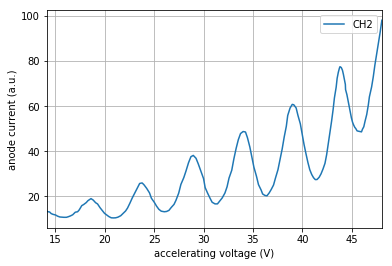

In [7]:
subdf.plot(x='CH1', y='CH2')
plt.xlabel('accelerating voltage (V)')
plt.ylabel('anode current (a.u.)')
plt.grid()
plt.show()

___
### Exercise 7: Finding the peaks/troughs

Use `signal.find_peaks` to find the peaks and troughs in the data. Try out various settings of the `distance` and `height` arguments (including not specifying them at all!). You will need to consult the documentation of this function!

Here are some hints:
   * `signal.find_peaks` takes only the Y values (`CH2`) and returns a tuple of `(peak_indices, peak_properties_dict)`. We only require the peak indices, which you can extract by suffixing the call with `[0]`, and assign this to a variable `peaks`.
   * To coerce `find_peaks` to find the troughs, what simple arithmetic operation should you apply to the input array? Assign the indices returned by `find_peaks` in this case to a variable named `troughs`.

Plot the peak/trough locations as points atop the data:
  * Extract the actual $(V, I)$ locations of these peaks/troughs by indexing `subdf` with `iloc[peaks]` for example. You can define the horizontal and vertical coordinates of these peaks/troughs using a single call along the lines of `V_peaks, I_peaks = subdf.iloc[peaks].values.T`.
  * Use these two arrays in a call to `plt.plot` and specify the formatting to be red/blue points using `fmt='ro'` or `fmt='bo'`.

#### Solution

In [8]:
peaks, _ = signal.find_peaks(subdf.CH2, distance=20)
troughs, _ = signal.find_peaks(x=-subdf.CH2, distance=20)

V_peaks, I_peaks = subdf.iloc[peaks].values.T
V_troughs, I_troughs = subdf.iloc[troughs].values.T

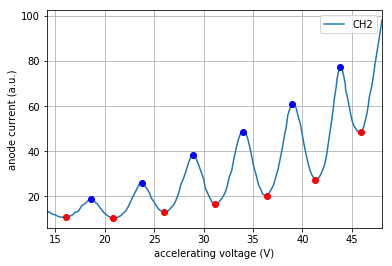

In [9]:
subdf.plot(x='CH1', y='CH2')
plt.plot(V_peaks, I_peaks, 'bo')
plt.plot(V_troughs, I_troughs, 'ro')
plt.xlabel('accelerating voltage (V)')
plt.ylabel('anode current (a.u.)')
plt.grid()
plt.show()

___
### Exercise 8: Finding the average peak separation

  * Determine the peak/trough separations using `np.diff`.
  * Find the mean separation of the peaks/troughs using `np.mean`.
  * Find the standard error in the mean using `np.std` and `np.sqrt`.

#### Solution

In [10]:
np.diff(V_peaks)

array([5.17543077, 5.17815   , 5.04307308, 4.97479359, 4.83268333])

In [11]:
np.diff(V_peaks).mean()

5.040826153846153

In [12]:
np.diff(V_peaks).std() / np.sqrt(len(peaks))

0.05312407587325883

Putting this all together, we get:

In [13]:
# Peak statistics
dV_peaks = np.diff(V_peaks)
dV_peaks_avg = dV_peaks.mean()
dV_peaks_std = dV_peaks.std() / np.sqrt(len(peaks))

# Trough statistics
dV_troughs = np.diff(V_troughs)
dV_troughs_avg = dV_troughs.mean()
dV_troughs_std = dV_troughs.std() / np.sqrt(len(troughs))

# Average the averages
dV_avg = np.mean([dV_peaks_avg, dV_troughs_avg])
dV_std = np.hypot(dV_peaks_std, dV_troughs_std)

# Print a summary
print(f"Average splitting (peaks): {dV_peaks_avg:.3f} +/- {dV_peaks_std:.3f} V")
print(f"Average splitting (troughs): {dV_troughs_avg:.3f} +/- {dV_troughs_std:.3f} V")
print(f"Average splitting (combined): {dV_avg:.3f} +/- {dV_std:.3f} V")

Average splitting (peaks): 5.041 +/- 0.053 V
Average splitting (troughs): 4.978 +/- 0.082 V
Average splitting (combined): 5.010 +/- 0.097 V


_Note:_ The uncertainty propagation and reporting can be greatly simplified using the excellent `uncertainties` package:

In [14]:
from uncertainties import ufloat

dV_peaks_ufloat = ufloat(dV_peaks_avg, dV_peaks_std)
dV_troughs_ufloat = ufloat(dV_troughs_avg, dV_troughs_std)
dV_ufloat = (dV_peaks_ufloat + dV_troughs_ufloat) / 2

print(f"Average splitting (peaks): {dV_peaks_ufloat:.1uS} V")
print(f"Average splitting (troughs): {dV_troughs_ufloat:.1uS} V")
print(f"Average splitting (combined): {dV_ufloat:.1uS} V")

Average splitting (peaks): 5.04(5) V
Average splitting (troughs): 4.98(8) V
Average splitting (combined): 5.01(5) V


___
### Exercise 9: Checking the linearity of the peak/trough positions

Plot the peak/trough locations (in volts) versus peak number.
  * Call `plt.plot` with only one array of values, namely `V_peaks` or `V_troughs`, and the horizontal axis will automatically range from 0 to `len(V_peaks)-1`.
  * Perform linear regression using `lmfit` to the peak locations to determine the average splitting.
  * Specify a `label` argument for each call to `plt.plot`.
  * Label the axes, add a grid, and a legend (using `plt.legend()`).

#### Solution

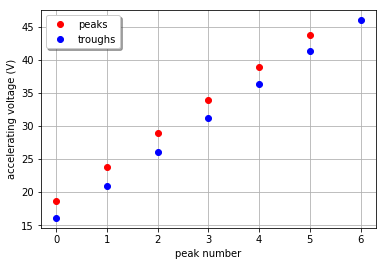

In [15]:
plt.plot(V_peaks, 'ro', label='peaks')
plt.plot(V_troughs, 'bo', label='troughs')
plt.xlabel('peak number')
plt.ylabel('accelerating voltage (V)')
plt.legend(shadow=True)
plt.grid()
plt.show()

___
### Exercise 10: Quantify the linearity of the splittings using linear regression

  * Define a linear model by creating an instance of `lmfit.models.LinearModel()` and assigning it to `linear`.
  * Perform regression to the data by calling `linear.fit(V_peaks, x=np.arange(len(V_peaks))`. The second argument specifies that the independent variable should be integers ranging from 0 to `len(peaks)-1`. Assign the fit result to a variable named `fit`.
  * Plot this fit using `fit.plot()`.
  * Report the fit results using `print(fit.fit_report())`.

#### Solution

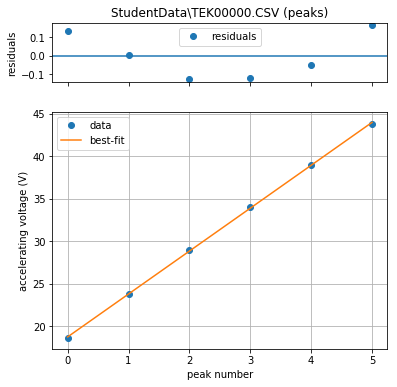

[[Model]]
    Model(linear)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 6
    # data points      = 6
    # variables        = 2
    chi-square         = 0.07817343
    reduced chi-square = 0.01954336
    Akaike info crit   = -22.0435093
    Bayesian info crit = -22.4599904
[[Variables]]
    intercept:  18.7255924 +/- 0.10117805 (0.54%) (init = 0)
    slope:      5.04719363 +/- 0.03341801 (0.66%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(intercept, slope) = -0.826



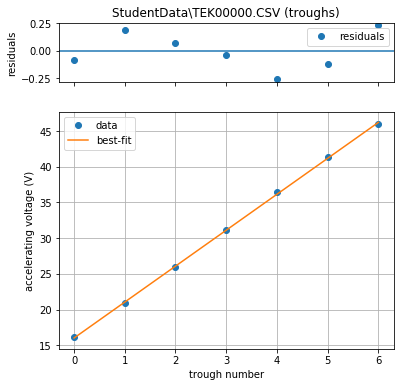

[[Model]]
    Model(linear)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 6
    # data points      = 7
    # variables        = 2
    chi-square         = 0.18624956
    reduced chi-square = 0.03724991
    Akaike info crit   = -21.3860456
    Bayesian info crit = -21.4942253
[[Variables]]
    intercept:  16.0204503 +/- 0.13150894 (0.82%) (init = 0)
    slope:      5.03131971 +/- 0.03647402 (0.72%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(intercept, slope) = -0.832



In [16]:
linear = lmfit.models.LinearModel()

# Fit to the peak locations
peak_fit = linear.fit(V_peaks, x=np.arange(len(V_peaks)))

fig, gs = peak_fit.plot()
fig.axes[1].grid()
fig.axes[1].set_xlabel('peak number')
fig.axes[1].set_ylabel('accelerating voltage (V)')
fig.axes[0].set_title(filepath + ' (peaks)')
plt.show()

print(peak_fit.fit_report())

# Fit to the trough locations
trough_fit = linear.fit(V_troughs, x=np.arange(len(V_troughs)))

fig, gs = trough_fit.plot()
fig.axes[1].grid()
fig.axes[1].set_xlabel('trough number')
fig.axes[1].set_ylabel('accelerating voltage (V)')
fig.axes[0].set_title(filepath + ' (troughs)')
plt.show()

print(trough_fit.fit_report())

___
### _Extension:_ Phenomenological multi-peak modelling

`scipy.signal.find_peaks` does an okay job at locating the peaks/troughs, but it's interesting to see if we can fit the data using a phenomenological model, based on a sum of troughs atop a polynomial background. For this, we construct a many-parameter custom model from `lmfit.models.PolynomialModel` and several instances of `lmfit.models.GaussianModel`.

_Note:_ This section requires pre-evaluation of the prior sections with particular variable names (those suggested).

In [17]:
# Polynomial model only
poly = lmfit.models.PolynomialModel(2)

# Multi-trough + quadratic model
model = lmfit.models.PolynomialModel(2)
for i in range(len(troughs)):
    model -= lmfit.models.GaussianModel(prefix=f"p{i}_")

params = model.make_params()

We must specify initial estimates for the fit parameters. These can be fairly crude estimates, but it pays to plot the model evaluated using these initial guesses atop the data. The closer you can get with the initial guesses, the faster the nonlinear regression will converge.

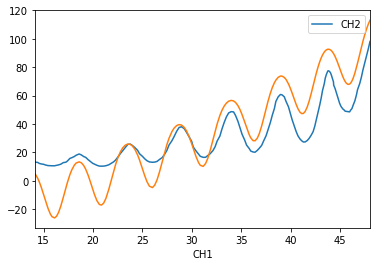

In [18]:
for i, V_i in enumerate(V_troughs):
    params[f"p{i}_center"].set(V_i)
    params[f"p{i}_sigma"].set(1)
    params[f"p{i}_amplitude"].set(100)
    
for i in range(3):
    params[f"c{i}"].set(0.05)

subdf.plot(x='CH1', y='CH2')
plt.plot(subdf.CH1, model.eval(params=params, x=subdf.CH1))

Now we go for broke and attempt the fut using the initial parameter estimates.

_Note_: Depending on the number of troughs and the initial parameter estimates, this may take a minute or so.

In [19]:
raw_fit = model.fit(data=subdf.CH2, x=subdf.CH1, params=params)

Plotting the fit, along with the polynomial contribution.

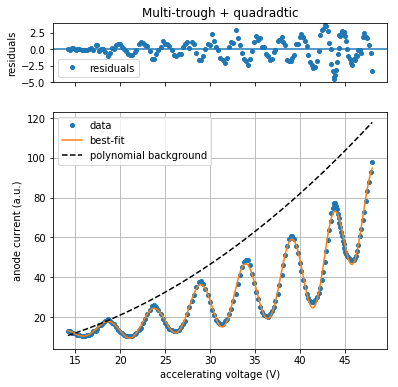

In [20]:
fig, gs = raw_fit.plot(data_kws={'ms': 4})
fig.axes[0].set_title('Multi-trough + quadradtic')
fig.axes[1].plot(subdf.CH1, poly.eval(params=params, x=subdf.CH1), 'k--', label='polynomial background')
fig.axes[1].legend()
fig.axes[1].grid()
fig.axes[1].set_xlabel('accelerating voltage (V)')
fig.axes[1].set_ylabel('anode current (a.u.)')
plt.show()

In [21]:
raw_fit.params

name,value,standard error,relative error,initial value,min,max,vary,expression
c0,-302.046149,586.606596,-194.21%,0.05,-inf,inf,True,
c1,32.6806467,64.5993457,197.67%,0.05,-inf,inf,True,
c2,-0.49907169,1.07641366,-215.68%,0.05,-inf,inf,True,
p0_sigma,2.71148566,2.05793684,75.90%,1,0.00000000,inf,True,
p0_center,17.1928558,1.49024425,8.67%,16.104725,-inf,inf,True,
p0_amplitude,601.478571,1789.76879,297.56%,100,-inf,inf,True,
p1_sigma,1.96564968,0.37038288,18.84%,1,0.00000000,inf,True,
p1_center,21.4431859,0.30496410,1.42%,20.86006153846154,-inf,inf,True,
p1_amplitude,496.243511,546.027560,110.03%,100,-inf,inf,True,
p2_sigma,2.70566789,1.55420777,57.44%,1,0.00000000,inf,True,


We now extract those fit parameters corresponding to the peak locations (value and standard error).

In [22]:
V_troughs_fit = np.array([raw_fit.params[x].value for x in raw_fit.params if 'center' in x])
u_V_troughs_fit = np.array([raw_fit.params[x].stderr for x in raw_fit.params if 'center' in x])

We can again perform linear regression to the trough locations, this time weighting the fit by the parameter uncertainties.

In [23]:
fit2 = linear.fit(V_troughs_fit, x=np.arange(len(V_troughs_fit)), weights=1/u_V_troughs_fit)

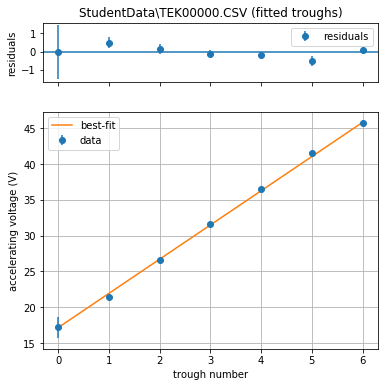

In [24]:
fig, gs = fit2.plot()
fig.axes[1].grid()
fig.axes[1].set_xlabel('trough number')
fig.axes[1].set_ylabel('accelerating voltage (V)')
fig.axes[0].set_title(filepath + ' (fitted troughs)')
plt.show()


In [25]:
print(fit2.fit_report(show_correl=False))

[[Model]]
    Model(linear)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 7
    # variables        = 2
    chi-square         = 9.77319768
    reduced chi-square = 1.95463954
    Akaike info crit   = 6.33613491
    Bayesian info crit = 6.22795521
[[Variables]]
    intercept:  17.1535973 +/- 0.28747966 (1.68%) (init = 0)
    slope:      4.77798854 +/- 0.05769670 (1.21%) (init = 1)



For these data, this turns out to have a greater uncertainty than linear regression to the results of `find_peaks`, and is further from the accepted value for the energy splitting in Hg.

Is there any variation of the splitting with peak number? [Rapior, Sengstock, and Baev, Am. J. Phys. **74**, 423 (2006)](https://doi.org/10.1119/1.2174033) suggests there might be for lower temperatures. (These data correspond to 200 degrees celcius.)

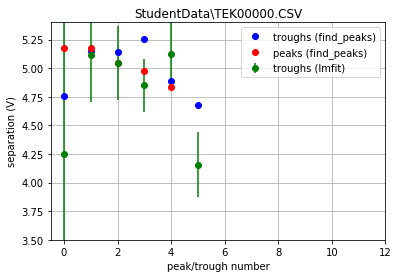

In [26]:
dV_troughs_fit = np.diff(V_troughs_fit)
u_dV_troughs_fit = [np.hypot(*u_V_troughs_fit[[i,i+1]]) for i in range(len(troughs)-1)]

plt.plot(dV_troughs, 'bo', label='troughs (find_peaks)')
plt.plot(dV_peaks, 'ro', label='peaks (find_peaks)')
plt.errorbar(x=range(len(dV_troughs_fit)), y=dV_troughs_fit, yerr=u_dV_troughs_fit, ls='none', marker='o', color='g', label='troughs (lmfit)')
plt.axis(xmin=-0.5, xmax=12, ymin=3.5, ymax=5.4)
plt.xlabel('peak/trough number')
plt.ylabel('separation (V)')
plt.legend()
plt.grid()
plt.title(filepath)
plt.show()